# Presto Demo Implementation
Drives functionality for the Presto demo notebook.

This was moved to a separate notebook so that the demo notebook stays as focused as possible on inputting search criteria and outputting results.

In [71]:
import io
import time
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle
import numpy as np

import pandas as pd

import shared.query as q
import shared.viz as viz

viz.set_style()

In [83]:
# Search input
type = 'Album' # possibilities: Book, Album, Artist, Author
search = 'The Pleasure Principle'
#search = 'No Results Found'
exact_match = True

# recommender/output settings
max_search_results = 10
max_recommendations = 10
recommender_user_pool_size = 10
recommender_product_pool_size = 100

# other settings
save_screenshot = False
log_verbosity = 1
include_subtitles = True

In [84]:
##################################
# Viz
# Show product data and recommendations
#################################

def inches_from_points(x):
    return x / 72

def inches_from_fontsize(x):
    # Quick fix for estimating text layouts. This is extremely similar to inches from points, except 
    # that texts include slight intrinsic padding beyond their point size.
    fudge_factor = 1.4 # this fudge factor is much larger than expected
    return inches_from_points(x) * fudge_factor 

# Settings
figure_width = 7 # A4 printer paper size: 8.3in x 11.7in
max_line_width = 100
figure_margin_x = 0.5
figure_margin_y = 0.5
figure_backgound_color = 'w'

vertical_margin = inches_from_points(36)
vertical_spacing = inches_from_points(12)
horizontal_margin = inches_from_points(36)

header_height = 0.25
header_font_size = 15
title_font_size = 13
title_text_limit = 50
subtitle_font_size = 10

body_font_size = 11

# Search results section
main_product_font_size = 21
main_product_subtitle_size = 13
subtitle_color = ('k', 0.6)
per_result_height = 0.5

# Recommendation section
per_recommendation_height = 0.6

# Utils
def add_section(height, title: str = None) -> tuple:
    """
    Creates a new figure with an optional new header.

    Using separate figures for separate sections of results is by convenience more than by design. 
    Matplotlib makes dynamic vertical layouts very difficult, and using separate figures is the most 
    expedient workaround for a dynamic multi-section layout.
    """
    fig = plt.figure(figsize = (figure_width, height))
    fig.set_facecolor('w')
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.set_xlim(0, fig.get_figwidth())
    ax.set_ylim(0, fig.get_figheight())
    if title:
        ax.set_title(title, loc = 'left', fontsize = header_font_size)
    return fig, ax
    
def add_box(ax, edgecolor = None, facecolor = ('k', 0.05)):
    """
    Debug inspection utility
    """
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.add_patch(Rectangle(xy = (x0,y0), width = x1 - x0, height = y1 - y0, edgecolor = edgecolor, facecolor = facecolor))

def product_subtitle(product: pd.Series) -> str:
    if not product.creator:
        return f'Unknown {'Author' if product.category == 'Books' else 'Artist'}'
    # to do: add date
    return f'by {product.creator}'


def wrap_text(text: str, max_line_width):
    if not isinstance(text, str):
        return text
    words = text.split()
    lines = []
    current_line = ''
    for word in words:
        # Check if adding this word exceeds the max width
        if len(current_line) + len(word) > max_line_width:
            # If it does, finalize the current line and start a new one
            lines.append(current_line)
            current_line = word
        else:
            # Otherwise, add the word to the current line
            if len(current_line) > 0:
                current_line += ' '
            current_line += word
    # Add the last line if it's not empty
    if current_line:
        lines.append(current_line)
    return "\n".join(lines)


In [85]:
def visualize_results(results: dict, category, search, include_subtitles):
    # Header: explain search
    header_text = f'{category} matching {repr(search)}:'
    fig_results, ax = add_section(header_height)
    ax.annotate(header_text, xy = (0,header_height), fontsize = header_font_size, verticalalignment = 'top')

    product = results['result']
    products = results['results']
    recommendations = results['recommendations']
    
    # special case: no results
    if product is None:
        height = inches_from_points(body_font_size)
        _, ax = add_section(height)
        ax.annotate(f'No results found. Try another search.', xy = (0,height), fontsize = body_font_size, verticalalignment = 'top')
    else:
        # Show the best match:
        # Gettig the layout right is difficult. Matplotlib does layout from bottom to top (in math coordinates, not paper/screen coordinates).
        # We don't want to lay out from bottom to top though because the large description on the bottom is the most error-prone, so we want to save it for last.
        desc = wrap_text(product.description, max_line_width)
        lines = len(desc.splitlines())
        
        title_top = vertical_margin 
        subtitle_top = title_top + inches_from_fontsize(main_product_font_size) + vertical_spacing
        description_top = subtitle_top + inches_from_fontsize(main_product_subtitle_size) + vertical_margin
        description_height = lines * inches_from_fontsize(body_font_size) # add padding for line spacing?
        product_details_height = description_top + description_height
        #print(f'product_details_height = {description_top} + {description_height} + {vertical_margin}')
    
        section_title = 'Your Match:' if len(products) == 1 else f'Best Match from {len(products)} results:'
        fig_product, ax = add_section(height = product_details_height, title = section_title)

        # Lay out components based on computed layout. 
        # Remember to convert to matplotlib coordinates, where the y axis starts at the bottom

        # title + subtitle
        def to_matplotlib(screen_y):
            return product_details_height - screen_y
        
        title = ax.annotate(f'{product.title}', xy = (0,to_matplotlib(title_top)), fontsize = main_product_font_size, verticalalignment = 'top')
        subtitle = ax.annotate(product_subtitle(product), xy = (0, to_matplotlib(subtitle_top)), fontsize = main_product_subtitle_size, color = subtitle_color, verticalalignment = 'top')
        description = ax.annotate(desc, xy = (0, to_matplotlib(description_top)), fontsize = body_font_size, verticalalignment = 'top')

        # Show other matches, if any
        # To do

        # Show ratings
        recommendation_column_widths = [0.8, 0.2]
        ratings_width = recommendation_column_widths[0] * figure_width
        ratings_width = 0.5 * figure_width

        ratings_size = (ratings_width, 3)
        reviews = results['reviews'].copy()
        fig_ratings = plt.figure(figsize = ratings_size)
        fig_ratings.set_facecolor('w')
        viz.plot_ratings(reviews.rating, color = 'C1')

        ##################
        # Recommendations!
        ##################
        title = f'People who liked {product.title} also liked:'

        recommendations = results['recommendations'].copy()
        recommendations = recommendations[:max_recommendations]
        # invert y for matplotlib - in math, y starts from the bottom and moves up. When showing a list though, y starts from the top and moves down.
        recommendations = recommendations[::-1]
        count = len(recommendations)

        # Create columns as subplots for a table-like display:
        # Title | Similarity
        title_column = ''   # Spelling out title crowds out the UI, and the column seems self-explanatory
        columns = [title_column, 'Similarity']
        # constrained_layout is to match the layout system used in the rest of the chart
        # Subplot mosaic uses a tighter layout system than the default, so mixing a subplot mosaic with 
        # default subplots leads to misalignment.
        fig, axs = plt.subplot_mosaic([columns], width_ratios = recommendation_column_widths, constrained_layout = True) 
        fig_recommendations = fig
        fig.set_facecolor('w')
        fig.set_figwidth(figure_width)
        fig.set_figheight(per_recommendation_height * count)
        # Nudging y up above 1 increases the title spacing between the figure title and the figure
        # Note that the more intuitive approach of using suplot_adjust does not work because constrained layout does not support it.
        text = plt.suptitle(title, horizontalalignment = 'left', x = 0, y = 1.075, fontsize = header_font_size)
        for label, ax in axs.items():
            ax.set_axis_off()
            ax.set_title(label, loc = 'left')
    
        # product / title column
        ax = axs[title_column]
        ys = recommendations.index
        bars = ax.barh(ys, width = recommendation_column_widths[0] * figure_width, height = 1, color = 'w')
        for i, index, bar in zip(range(count), ys, bars):
            product = recommendations.loc[index]
            title = product.title
            subtitle = product_subtitle(product)
            midy = bar.get_center()[1]
            if len(title) > title_text_limit:
                title = title[:title_text_limit] + '…'
            # to do: find a way to present creators/subtitles without adversely impacting the existing layout
            if include_subtitles:
                ax.annotate(
                    title, 
                    xy = (0, midy), 
                    fontsize = title_font_size,
                    verticalalignment = 'bottom', 
                    xytext = (0, vertical_spacing), textcoords = 'offset points'
                )
                ax.annotate(
                    subtitle,
                    xy = (0, midy),
                    verticalalignment = 'top',
                    fontsize = subtitle_font_size, color = subtitle_color,
                    xytext = (0, -vertical_spacing), textcoords = 'offset points'
                )
            else: 
                ax.annotate(
                    title, 
                    xy = (0, midy), 
                    fontsize = title_font_size,
                    verticalalignment = 'center',
                )

    
        # relevance column
        ax = axs['Similarity']
        xs = recommendations.similarity
        # xs = [0.25 + 0.6 * x / count for x in range(count)] # uncomment to test similarity bar
        viz.plot_rates(ys, xs, label_inside_bar_cutoff = 0.5)

        # make 'screenshot' from the above results
        if save_screenshot:
            def image_from_figure(figure) -> Image:
                buf = io.BytesIO()
                figure.savefig(buf, format = 'png', bbox_inches = 'tight')
                buf.seek(0)
                img = Image.open(buf)
                img.load()
                buf.close()
                return img
            
            images = [image_from_figure(figure) for figure in [fig_results, fig_product, fig_ratings, fig_recommendations]]
            dpi = plt.rcParams['savefig.dpi']
            yspacing = round(0.5 * dpi)
            max_width = max(image.width for image in images)
            total_height = sum(image.height for image in images) + yspacing * (len(images) - 1)

            collage = Image.new(mode = 'RGB', size = (max_width, total_height), color = 'white')
            top = 0
            for image in images:
                collage.paste(image, box = (0, top))
                top += image.height + yspacing

            collage.save('../images/demo.png')
            fig = plt.figure(figsize = (max_width / dpi, total_height / dpi), dpi = dpi)
            plt.imshow(np.asarray(collage))

            


In [86]:
def output_recommendations(type: str, search_term: str, exact_match: bool, conn, include_subtitles = include_subtitles) -> dict:
    assert(type in set(['Artist', 'Album', 'Author', 'Book']))
    category = 'Books' if type in ('Author', 'Book') else 'Music'
    search_field = 'title' if type in ('Album', 'Book') else 'creator'
    t = time.perf_counter()
    results = q.get_recommendations(category, search, conn, search_field = search_field, verbosity = log_verbosity)
    elapsed = time.perf_counter() - t
    print(f"Found {search_term} recommendations in {elapsed:.3f} seconds")
    visualize_results(results, category, search_term, include_subtitles=include_subtitles)
    return results

find_products: 8 results in 0.010 seconds
0.0174: Found 4 products
0.0451: Got 80 reviews
0.0789: Got 3531 related reviews of 3274 products by 80 users
0.0834: Filtered 1257 related reviews by user and/or product
0.0893: Created ratings table for 1000 products by 80 users
0.101: Calculated similarities
0.232: Removed 10 duplicate editions of the same product
0.232: Added product details
Found The Pleasure Principle recommendations in 0.233 seconds


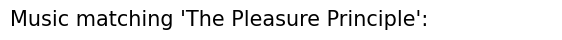

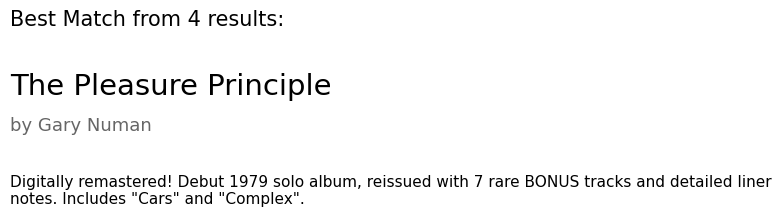

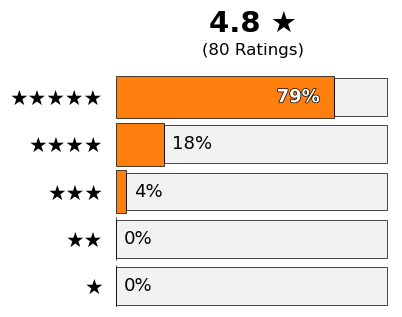

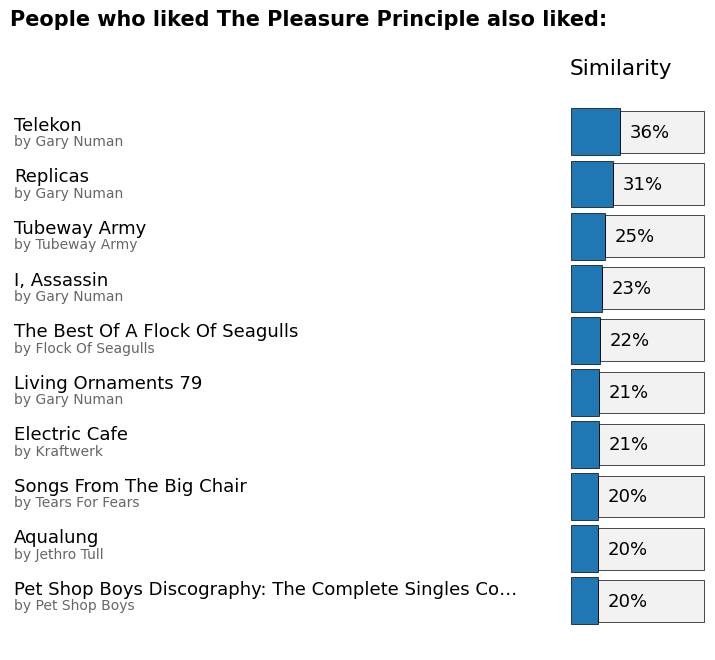

In [87]:
test = True
if test:
    conn = q.connect()
    output_recommendations(type, search, exact_match, conn)

In [88]:
if test:
    conn.close()